# Vision por Computadora I - CEIA

## Trabajo Practico N° 4

#### Autor: Juan Ignacio Ribet

▪ Implementar el detector de fondo naive usando la mediana como
estimador. El algoritmo debe recibir el parámetro N (cantidad de
frames utilizados para la estimación) y el intervalo de tiempo para
recalcular el fondo.

▪ Se deben generar las mascaras de foreground y aplicarlas a los frames
para segmentar los objetos en movimiento.

▪ Comparar con alguno de los métodos vistos en la practica basados en
mezcla de gaussianas

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

Defino la funcion 'get_background' para obtener el fondo en un video

In [2]:
def get_background(video_path, start_frame, N=200, time= False, plot_background=False):
    '''
    Funcion para obtener el 'backgound' de un video

    :video_path: ubicaion del video
    :start_frame: Frame donde se empeiza a tomar el 'backgound'
    :N: cantidad de frames utilizados para la estimación del fondo (default: 200)
    :time: intervalo de tiempo para recalcular el fondo. Si time = False no se recalcula (default: False)
    :plot_background: si igual a True se plotea el fondo
    '''

    cap = cv.VideoCapture(video_path)
    frames = [] # Lista de frames para calcular la mediana

    N = 200 # cantidad de frames utilizados para la estimación
    if time != False:
        fps = cap.get(cv.CAP_PROP_FPS)
        frames_time = time*int(fps) # Frames en el intervalo de tiempo
    
    

    while cap.isOpened():
        
        success, image = cap.read()
        if not success:
            pass
        if image is None:
            break

        # Agrego las imagenes a las lista de frames para luego calcular la mediana
        if start_frame < int(cap.get(cv.CAP_PROP_POS_FRAMES)) <= start_frame+N:
            frames.append(image)

        # Proceso la imagen luego de intervalo de tiempo establesido
        if int(cap.get(cv.CAP_PROP_POS_FRAMES)) == start_frame+N:
            background = np.median(frames, axis=0).astype(dtype=np.uint8)
            # Mejoro la imagen
            kernel = np.array([[0,-1,0],
                            [-1,5,-1],
                            [0,-1,0]])
            background_for_plot = cv.filter2D(background, ddepth=-1, kernel=kernel)

            if plot_background == True:
                plt.title(f'Fondo en segundo: {int(start_frame/int(fps))}'); plt.axis('off');plt.imshow(background_for_plot[:,:,::-1]);plt.show()
                # Seteo el nuevo inicio de toma de imagenes
            if time != False:
                start_frame = start_frame+frames_time
            else:
                break

    cap.release()

    return background

## Punto 1:
▪ Implementar el detector de fondo naive usando la mediana como
estimador. El algoritmo debe recibir el parámetro N (cantidad de
frames utilizados para la estimación) y el intervalo de tiempo para
recalcular el fondo.

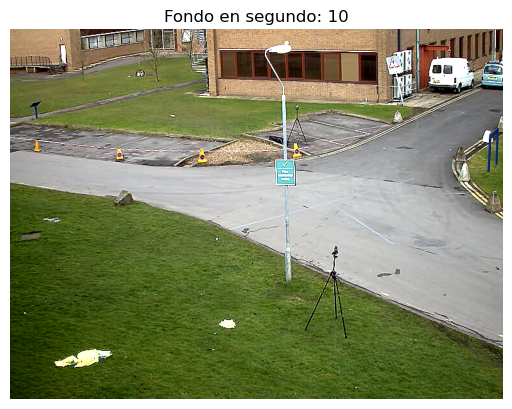

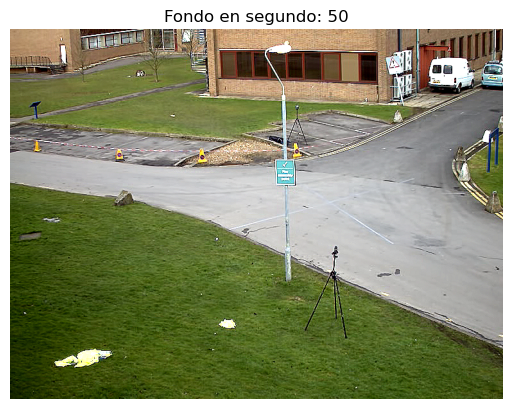

In [3]:
background = get_background('vtest.avi', 100, N=200, time= 40, plot_background=True)

Defino la función 'foreground_mask' para obtener las mascaras de metodo mediana o  metodo basado en mezcla de gaussianas MOG2

In [4]:
def foreground_mask(video_path, 
                    method, 
                    print_frame: int() = False,
                    show_videos = True):
    '''
    Función para generar las máscaras de foreground y aplicarlas a los frames 
    para segmentar los objetos en movimiento de método por cálculo de mediana (1) y método basado 
    en mezcla de gaussianas MOG2

    :video_path: ubicación  del video
    :method: 1: Mediana, 2: MOG2, 'both': Ambos
    :print_frame: int(): Imprime el frame indicado, si False no imprime (Default: False)
    :show_videos: Muestra los videos generados
    '''

    cap = cv.VideoCapture(video_path)
    prev_frame_time = 0
    new_frame_time = 0
    FPSs = []

    if (method == 1) or (method == 'both'):
        print('Obtenbiendo el "background" para el metodo mediana')
        background = get_background(video_path, 100)
        background_gray = cv.cvtColor(background, cv.COLOR_BGR2GRAY)
        print('"background" obtenido')
    # Comparo con el metodo MOG
    if (method == 2) or (method == 'both'):
        backSub = cv.createBackgroundSubtractorMOG2()

    while cap.isOpened():
        
        success, image = cap.read()

        if image is None:
            break
        if not success:
            pass
        
        # Mido FPS
        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time    
        fps = int(fps)
        FPSs.append(fps)

        if show_videos == True:
            # Escribimos sobre la imagen el número de frame procesado
            cv.rectangle(image, (10, 2), (150,20), (255,255,255), -1)
            cv.putText(image, f'Frame: {str(cap.get(cv.CAP_PROP_POS_FRAMES))}', (15, 15),
                    cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

            if (print_frame != False) & (int(cap.get(cv.CAP_PROP_POS_FRAMES)) == print_frame):
                plt.title('Frame'); plt.axis('off');plt.imshow(image[:,:,::-1]);plt.show()
            
            cv.imshow('Video orig', image)
        
        # Aplico el metodo del punto 2
        if (method == 1) or (method == 'both'): 
            img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            image_seg = cv.subtract(background_gray,img_gray)
            _,image_seg = cv.threshold(image_seg,20,255,cv.THRESH_BINARY)
            cv.rectangle(image_seg, (10, 2), (150,20), (255,255,255), -1)
            cv.putText(image_seg, f'FPS: {str(fps)}', (15, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
            
            if (print_frame != False) & (int(cap.get(cv.CAP_PROP_POS_FRAMES)) == print_frame):
                plt.title('FG Median'); plt.axis('off');plt.imshow(image_seg, cmap='gray');plt.show()
            if show_videos == True:
                cv.imshow('FG Median', image_seg)

        # Aplicamos la sustracción al frame leído
        if (method == 2) or (method == 'both'):
            fgMask = backSub.apply(image)
            cv.rectangle(fgMask, (10, 2), (150,20), (255,255,255), -1)
            cv.putText(fgMask, f'FPS: {str(fps)}', (15, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

            if (print_frame != False) & (int(cap.get(cv.CAP_PROP_POS_FRAMES)) == print_frame):
                plt.title('FG Mask'); plt.axis('off');plt.imshow(fgMask, cmap='gray');plt.show()
            if show_videos == True:
                cv.imshow('FG Mask', fgMask)
        
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

    FPSs = np.array(FPSs)
    return FPSs

## Punto 2:

▪ Se deben generar las mascaras de foreground y aplicarlas a los frames
para segmentar los objetos en movimiento.

Obtenbiendo el "background" para el metodo mediana
"background" obtenido


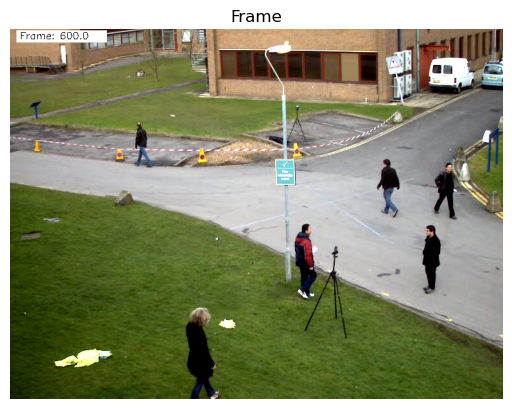

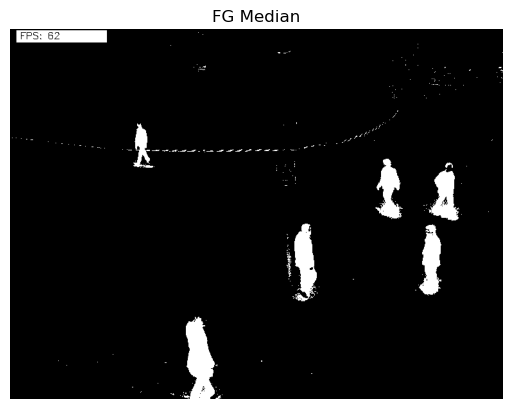

In [5]:
FPSs = foreground_mask('vtest.avi', method = 1,print_frame = 600)

## Punto 3:
▪ Comparar con alguno de los métodos vistos en la practica basados en
mezcla de gaussianas

Obtenbiendo el "background" para el metodo mediana
"background" obtenido


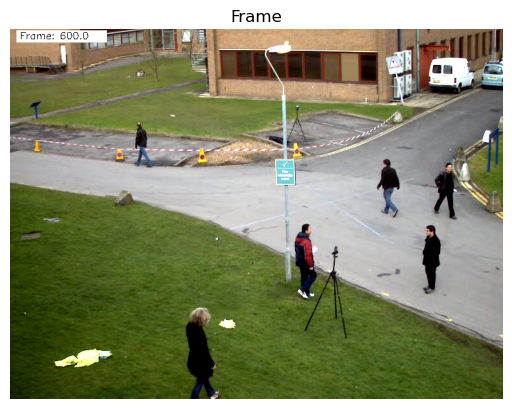

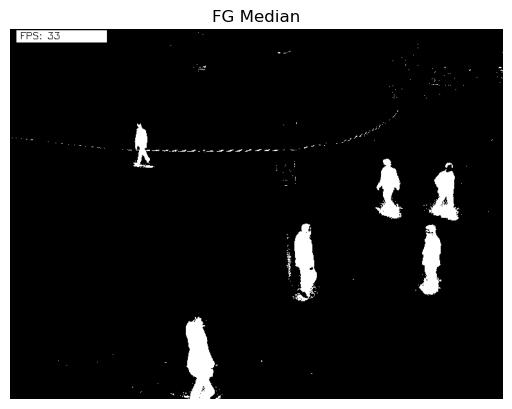

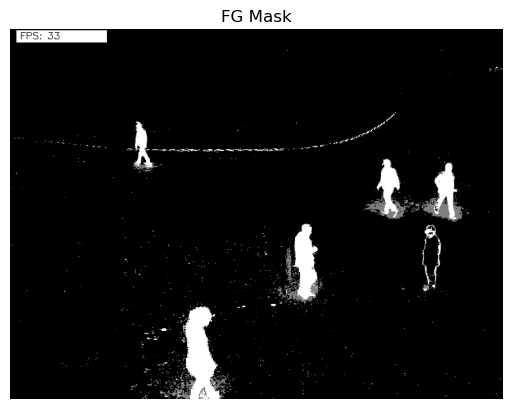

In [6]:
FPSs = foreground_mask('vtest.avi', method ='both' ,print_frame = 600)

In [10]:
median_fps = foreground_mask('vtest.avi', method =1 ,print_frame = False, show_videos = False)
print(f'FPS = {int(median_fps.mean())}')

Obtenbiendo el "background" para el metodo mediana
"background" obtenido
FPS = 63


In [11]:
FG_Mask_FPS = foreground_mask('vtest.avi', method = 2, print_frame = False, show_videos = False)
print(f'FPS = {int(FG_Mask_FPS.mean())}')

FPS = 31


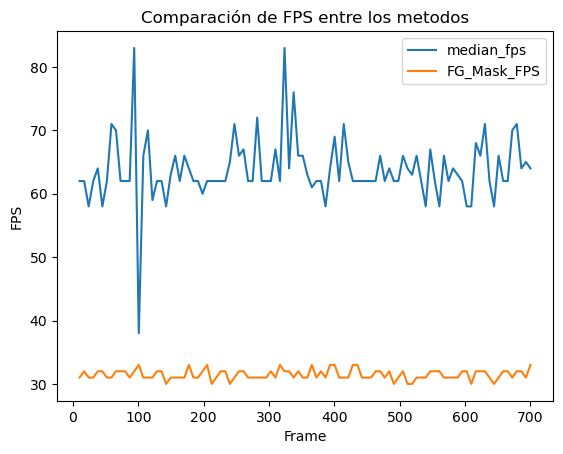

In [16]:
plt.title('Comparación de FPS entre los metodos')
plt.plot(np.linspace(10,700,100),[median_fps[int(i)] for i in np.linspace(10,700,100)], label='median_fps')
plt.plot(np.linspace(10,700,100),[FG_Mask_FPS[int(i)] for i in np.linspace(10,700,100)], label='FG_Mask_FPS')
plt.xlabel('Frame')
plt.ylabel('FPS')
plt.legend()

Se puede ver que en cuestión de velocidad es mucho más eficiente el método naive de mediana, aunque con mucha mayor variación, pero con el doble de FPS. En relación con la precisión no encontré grandes diferencias con este video. todas las personas fueron detectadas con ambos métodos lo que sí se puede apreciar en el método de cálculo de mediana es que cuando la intensidad del objeto a detectar es similar a la del fondo este se pierde como se ve en el pelo rubio de la persona en la parte inferior del frame impreso. Por otro lado, el método MOG2 se lo ve en general con mucho más ruido alrededor del objeto en movimiento.